# Laboratorium 10 - Równania różniczkowe zwyczajne – część II

In [118]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import fsolve, minimize
import pandas as pd


plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["legend.fontsize"] = 10

#### Definicja układu równań Lotki-Volterry

In [119]:
def lotka_volterra(variables, t, alpha1, beta1, alpha2, beta2):
    x, y = variables
    dxdt = x * (alpha1 - beta1 * y)
    dydt = y * (-alpha2 + beta2 * x)
    return [dxdt, dydt]


x0 = 20
y0 = 20
initial_conditions = [x0, y0]


alpha1 = 1
beta1 = 0.1
alpha2 = 0.5
beta2 = 0.02
params = (alpha1, beta1, alpha2, beta2)


t_start = 0
t_end = 80
dt = 0.01
time_points = np.arange(t_start, t_end, dt)

#### Jawna Metoda Eulera

In [120]:
def explicit_euler(func, initial_conditions, t_points, args):
    dt = t_points[1] - t_points[0]
    num_steps = len(t_points)
    x = np.zeros(num_steps)
    y = np.zeros(num_steps)

    x[0], y[0] = initial_conditions

    for i in range(num_steps - 1):
        dxdt, dydt = func([x[i], y[i]], t_points[i], *args)
        x[i + 1] = x[i] + dt * dxdt
        y[i + 1] = y[i] + dt * dydt
    return x, y


x_euler_exp, y_euler_exp = explicit_euler(
    lotka_volterra, initial_conditions, time_points, params
)


#### Niejawna Metoda Eulera
Wymaga rozwiązania nieliniowego układu równań w każdym kroku. Użyjemy `fsolve`.



In [121]:
def implicit_euler(func, initial_conditions, t_points, args):
    dt = t_points[1] - t_points[0]
    num_steps = len(t_points)
    x = np.zeros(num_steps)
    y = np.zeros(num_steps)

    x[0], y[0] = initial_conditions

    for i in range(num_steps - 1):
        current_x, current_y = x[i], y[i]

        # Funkcja do rozwiązania dla fsolve: F(x_new, y_new) = [0, 0]
        # x_new - x_old - dt * f(x_new, y_new) = 0
        # y_new - y_old - dt * g(x_new, y_new) = 0
        def equations_to_solve(vars_next):
            x_next, y_next = vars_next
            dxdt_next, dydt_next = func([x_next, y_next], t_points[i + 1], *args)
            eq1 = x_next - current_x - dt * dxdt_next
            eq2 = y_next - current_y - dt * dydt_next
            return [eq1, eq2]

        # Używamy bieżących wartości jako początkowego zgadnięcia dla fsolve
        solution = fsolve(equations_to_solve, [current_x, current_y])
        x[i + 1], y[i + 1] = solution
    return x, y


# UWAGA: Metoda niejawna Eulera dla tego układu może być niestabilna bez odpowiedniego zgadnięcia początkowego
# lub małego kroku czasowego, a także może wymagać bardzo precyzyjnych rozwiązań nieliniowych równań.
# Dla dużych dt może nie zbiegać lub dawać nierealistyczne wyniki.
# W przypadku Lotki-Volterry, która ma cykliczne rozwiązania, fsolve może mieć problemy ze znalezieniem prawidłowego rozwiązania
# jeśli punkt początkowy jest zbyt odległy od rzeczywistego rozwiązania.
# Dla celów demonstracyjnych i uniknięcia błędów, możemy ograniczyć dt lub użyć bardziej zaawansowanej metody do rozwiązywania równań nieliniowych.
# Jeśli pojawi się błąd "The solution did not converge", oznacza to, że fsolve nie znalazł rozwiązania.
try:
    x_euler_imp, y_euler_imp = implicit_euler(
        lotka_volterra, initial_conditions, time_points, params
    )
except Exception as e:
    print(f"Błąd podczas obliczeń niejawnej metody Eulera: {e}")
    print(
        "Spróbuj zmniejszyć dt lub zaimplementować inny solver dla układu nieliniowego."
    )
    x_euler_imp, y_euler_imp = (
        np.full_like(time_points, np.nan),
        np.full_like(time_points, np.nan),
    )  # Wypełnij NaN, jeśli nie udało się obliczyć

#### Półjawna Metoda Eulera
 Użyjemy wersji:
 $x_{n+1} = x_n + h_n f(x_n, y_{n+1})$
 $y_{n+1} = y_n + h_n g(x_n, y_{n+1})$

 Z drugiego równania możemy wyliczyć $y_{n+1}$ (jeśli $y_n$ i $g(x_n, y_{n+1})$ są odpowiednie), a potem $x_{n+1}$.

 Model Lotki-Volterry:
 $x_{n+1} = x_n + h_n \cdot x_n (\alpha_1 - \beta_1 y_{n+1})$
 $y_{n+1} = y_n + h_n \cdot y_{n+1} (-\alpha_2 + \beta_2 x_n)$

 Z drugiego równania:
 $y_{n+1} (1 - h_n (-\alpha_2 + \beta_2 x_n)) = y_n$
 $y_{n+1} = y_n / (1 + h_n \alpha_2 - h_n \beta_2 x_n)$

 A potem $x_{n+1}$:
 $x_{n+1} = x_n + h_n \cdot x_n (\alpha_1 - \beta_1 y_{n+1})$


In [122]:
def semi_implicit_euler(func, initial_conditions, t_points, args):
    dt = t_points[1] - t_points[0]
    num_steps = len(t_points)
    x = np.zeros(num_steps)
    y = np.zeros(num_steps)

    x[0], y[0] = initial_conditions
    alpha1, beta1, alpha2, beta2 = args

    for i in range(num_steps - 1):
        # Oblicz y_{n+1}
        denominator_y = 1 + dt * alpha2 - dt * beta2 * x[i]
        # Zabezpieczenie przed dzieleniem przez zero lub ujemnymi wartościami (co oznacza nielogiczną dynamikę)
        if denominator_y == 0:
            y[i + 1] = np.nan
        else:
            y[i + 1] = y[i] / denominator_y

        # Oblicz x_{n+1}
        # Model: x_{n+1} = x_n + h_n * x_n * (alpha1 - beta1 * y_{n+1})
        x[i + 1] = x[i] + dt * x[i] * (alpha1 - beta1 * y[i + 1])

        # Upewnij się, że populacje nie stają się ujemne
        x[i + 1] = max(0, x[i + 1])
        y[i + 1] = max(0, y[i + 1])

    return x, y


x_euler_semi_imp, y_euler_semi_imp = semi_implicit_euler(
    lotka_volterra, initial_conditions, time_points, params
)

#### Metoda Rungego-Kutty czwartego rzędu (RK4)

In [123]:
def rk4_solver(func, initial_conditions, t_points, args):
    dt = t_points[1] - t_points[0]
    num_steps = len(t_points)
    x = np.zeros(num_steps)
    y = np.zeros(num_steps)

    x[0], y[0] = initial_conditions

    for i in range(num_steps - 1):
        current_vars = [x[i], y[i]]

        k1_x, k1_y = func(current_vars, t_points[i], *args)

        vars_k2 = [current_vars[0] + dt * k1_x / 2, current_vars[1] + dt * k1_y / 2]
        k2_x, k2_y = func(vars_k2, t_points[i] + dt / 2, *args)

        vars_k3 = [current_vars[0] + dt * k2_x / 2, current_vars[1] + dt * k2_y / 2]
        k3_x, k3_y = func(vars_k3, t_points[i] + dt / 2, *args)

        vars_k4 = [current_vars[0] + dt * k3_x, current_vars[1] + dt * k3_y]
        k4_x, k4_y = func(vars_k4, t_points[i] + dt, *args)

        x[i + 1] = current_vars[0] + dt / 6 * (k1_x + 2 * k2_x + 2 * k3_x + k4_x)
        y[i + 1] = current_vars[1] + dt / 6 * (k1_y + 2 * k2_y + 2 * k3_y + k4_y)

        # Upewnij się, że populacje nie stają się ujemne
        x[i + 1] = max(0, x[i + 1])
        y[i + 1] = max(0, y[i + 1])

    return x, y


x_rk4, y_rk4 = rk4_solver(lotka_volterra, initial_conditions, time_points, params)

# Możemy również użyć wbudowanego solvera `odeint` dla porównania (rozwiązanie referencyjne)
solution_odeint = odeint(lotka_volterra, initial_conditions, time_points, args=params)
x_odeint, y_odeint = solution_odeint[:, 0], solution_odeint[:, 1]

#### Wykresy liczebności populacji w zależności od czasu

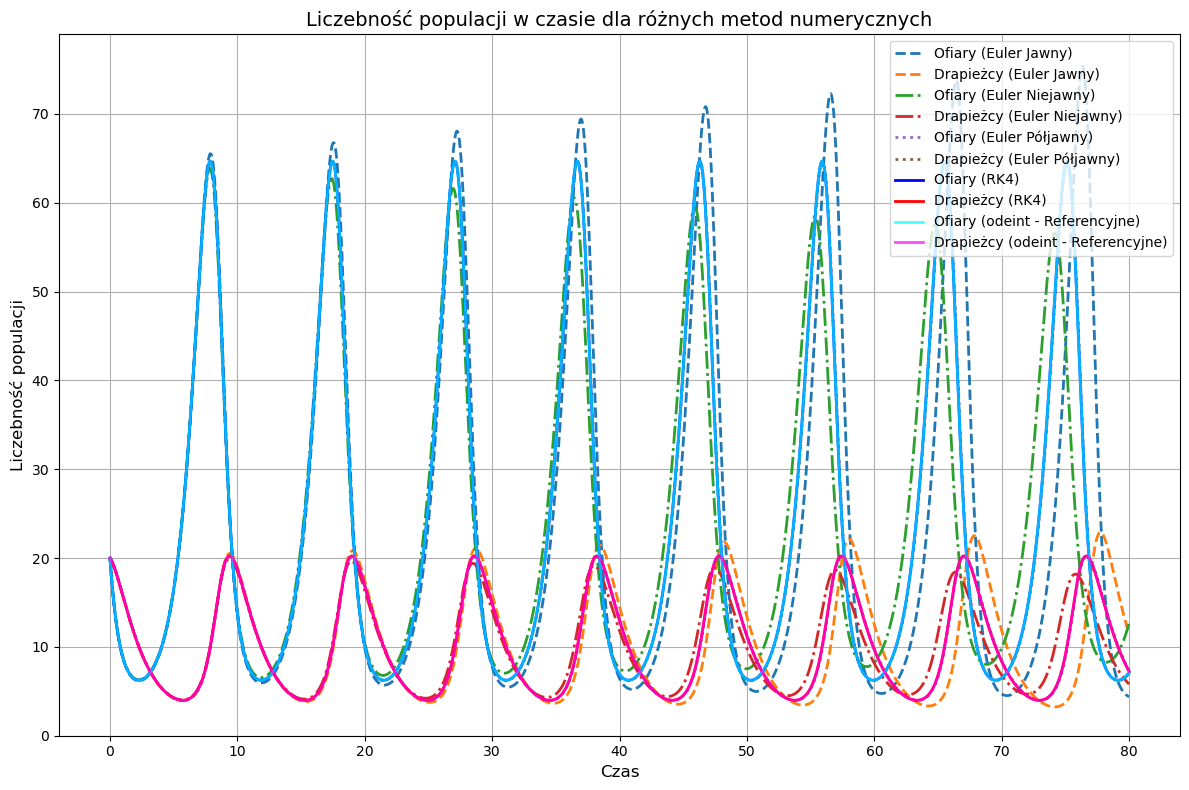

In [124]:
plt.figure(figsize=(12, 8))
plt.plot(time_points, x_euler_exp, label="Ofiary (Euler Jawny)", linestyle="--")
plt.plot(time_points, y_euler_exp, label="Drapieżcy (Euler Jawny)", linestyle="--")

if not np.all(np.isnan(x_euler_imp)):
    plt.plot(time_points, x_euler_imp, label="Ofiary (Euler Niejawny)", linestyle="-.")
    plt.plot(
        time_points, y_euler_imp, label="Drapieżcy (Euler Niejawny)", linestyle="-."
    )

plt.plot(time_points, x_euler_semi_imp, label="Ofiary (Euler Półjawny)", linestyle=":")
plt.plot(
    time_points, y_euler_semi_imp, label="Drapieżcy (Euler Półjawny)", linestyle=":"
)

plt.plot(time_points, x_rk4, label="Ofiary (RK4)", color="blue")
plt.plot(time_points, y_rk4, label="Drapieżcy (RK4)", color="red")

plt.plot(
    time_points,
    x_odeint,
    label="Ofiary (odeint - Referencyjne)",
    color="cyan",
    alpha=0.7,
)
plt.plot(
    time_points,
    y_odeint,
    label="Drapieżcy (odeint - Referencyjne)",
    color="magenta",
    alpha=0.7,
)


plt.title("Liczebność populacji w czasie dla różnych metod numerycznych")
plt.xlabel("Czas")
plt.ylabel("Liczebność populacji")
plt.grid(True)
plt.legend()
plt.ylim(bottom=0)  # Populacja nie może być ujemna
plt.tight_layout()
plt.show()

#### Portret fazowy

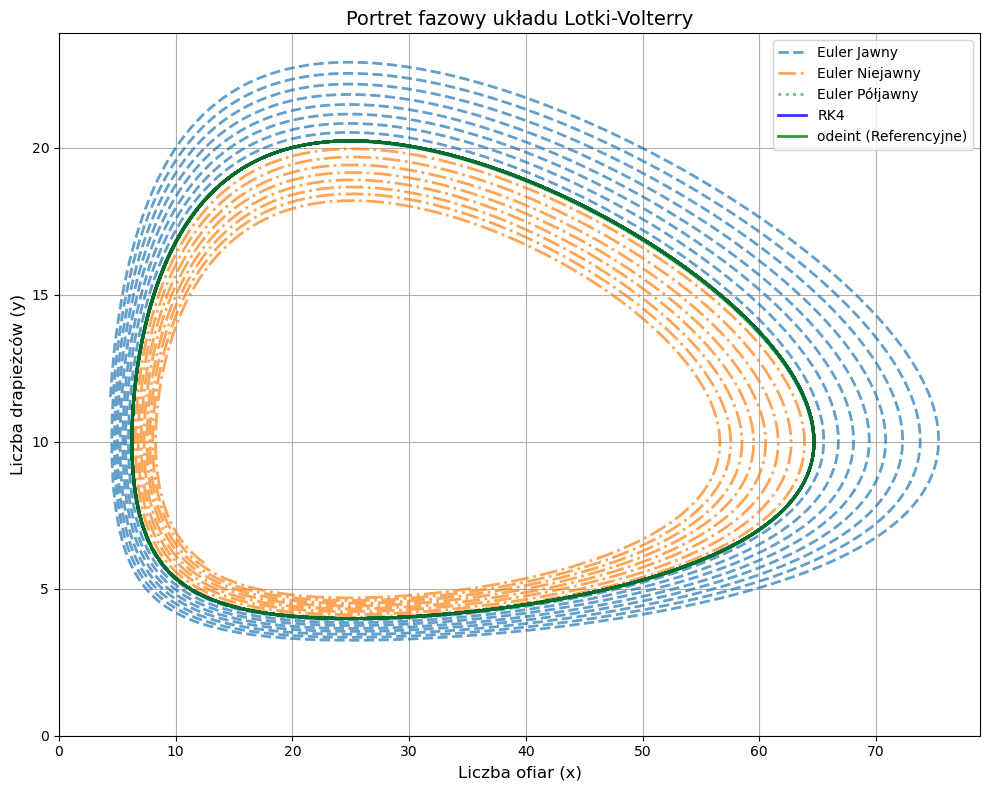

In [125]:
plt.figure(figsize=(10, 8))
plt.plot(x_euler_exp, y_euler_exp, label="Euler Jawny", linestyle="--", alpha=0.7)
if not np.all(np.isnan(x_euler_imp)):
    plt.plot(
        x_euler_imp, y_euler_imp, label="Euler Niejawny", linestyle="-.", alpha=0.7
    )
plt.plot(
    x_euler_semi_imp, y_euler_semi_imp, label="Euler Półjawny", linestyle=":", alpha=0.7
)
plt.plot(x_rk4, y_rk4, label="RK4", color="blue", alpha=0.8)
plt.plot(x_odeint, y_odeint, label="odeint (Referencyjne)", color="green", alpha=0.8)

plt.title("Portret fazowy układu Lotki-Volterry")
plt.xlabel("Liczba ofiar (x)")
plt.ylabel("Liczba drapieżców (y)")
plt.grid(True)
plt.legend()
plt.xlim(left=0)  # Populacja nie może być ujemna
plt.ylim(bottom=0)  # Populacja nie może być ujemna
plt.tight_layout()
plt.show()


 **Fizyczna Interpretacja Portretu Fazowego:**
 Portret fazowy przedstawia trajektorie układu w przestrzeni stanów $(x, y)$. Dla modelu Lotki-Volterry, trajektorie te są zamkniętymi krzywymi (eliptycznymi lub spiralnymi), co oznacza, że populacje drapieżców i ofiar oscylują cyklicznie.

 * Kiedy liczba ofiar jest wysoka, drapieżcy mają dużo pożywienia, ich populacja rośnie, a populacja ofiar maleje z powodu zwiększonego drapieżnictwa.
 * Kiedy liczba ofiar spada, drapieżcy mają mniej pożywienia, ich populacja maleje, co pozwala populacji ofiar się odbudować.
 * Wzrost liczby ofiar ponownie prowadzi do wzrostu liczby drapieżców, zamykając cykl.

 Centralny punkt, wokół którego oscylują trajektorie, to punkt równowagi (stacjonarny) układu, gdzie populacje nie ulegają zmianie. Różne metody numeryczne mogą wprowadzać różne artefakty (np. dryf spiralny) z powodu błędów dyskretyzacji. RK4 i `odeint` pokazują najbardziej stabilne i zbliżone do idealnych cykli, podczas gdy metody Eulera wykazują większy dryf.


 Rozwiązujemy układ równań:
 x(alpha1 - beta1 * y) = 0
 y(-alpha2 + beta2 * x) = 0

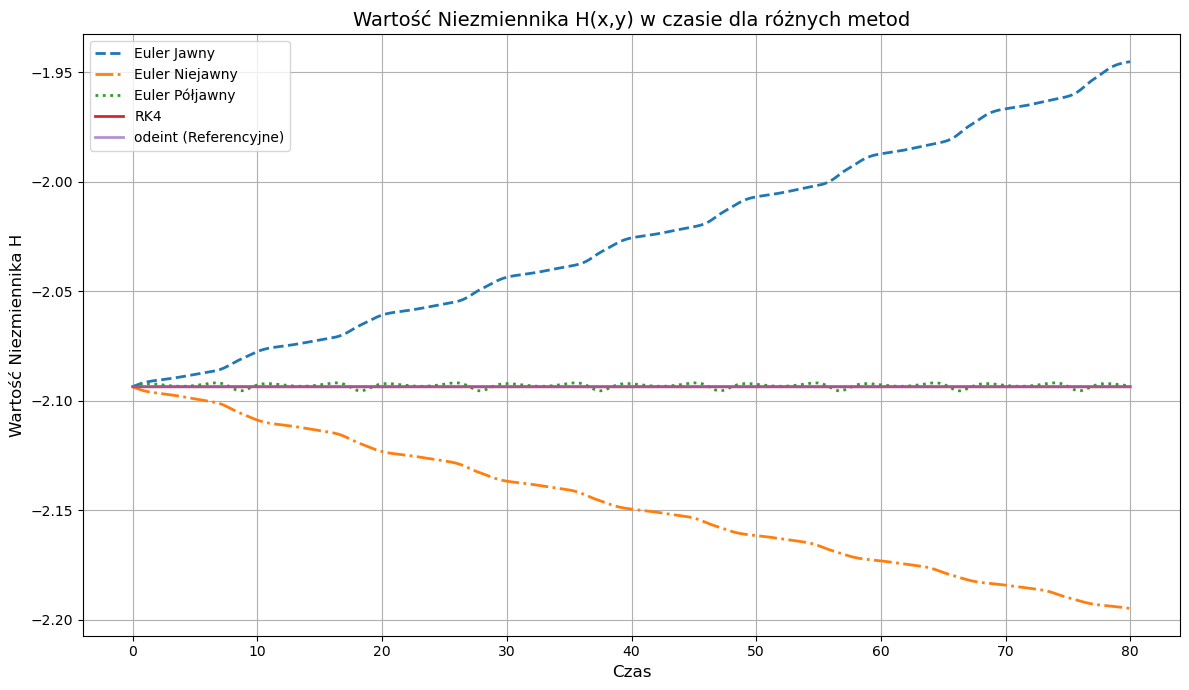

In [127]:
def calculate_invariant(x_vals, y_vals, alpha1, beta1, alpha2, beta2):
    # Unikamy logarytmu z zera lub wartości ujemnych
    x_safe = np.maximum(x_vals, 1e-9)  # Mała wartość, aby uniknąć log(0)
    y_safe = np.maximum(y_vals, 1e-9)
    return (
        beta2 * x_safe
        + beta1 * y_safe
        - alpha2 * np.log(x_safe)
        - alpha1 * np.log(y_safe)
    )


# Obliczenie niezmiennika dla każdej metody
H_euler_exp = calculate_invariant(x_euler_exp, y_euler_exp, *params)
if not np.all(np.isnan(x_euler_imp)):
    H_euler_imp = calculate_invariant(x_euler_imp, y_euler_imp, *params)
else:
    H_euler_imp = np.full_like(time_points, np.nan)

H_euler_semi_imp = calculate_invariant(x_euler_semi_imp, y_euler_semi_imp, *params)
H_rk4 = calculate_invariant(x_rk4, y_rk4, *params)
H_odeint = calculate_invariant(x_odeint, y_odeint, *params)

# Wykres niezmiennika w zależności od czasu
plt.figure(figsize=(12, 7))
plt.plot(time_points, H_euler_exp, label="Euler Jawny", linestyle="--")
if not np.all(np.isnan(H_euler_imp)):
    plt.plot(time_points, H_euler_imp, label="Euler Niejawny", linestyle="-.")
plt.plot(time_points, H_euler_semi_imp, label="Euler Półjawny", linestyle=":")
plt.plot(time_points, H_rk4, label="RK4")
plt.plot(time_points, H_odeint, label="odeint (Referencyjne)", alpha=0.7)

plt.title("Wartość Niezmiennika H(x,y) w czasie dla różnych metod")
plt.xlabel("Czas")
plt.ylabel("Wartość Niezmiennika H")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


 **Analiza zachowania niezmiennika:**
 W teorii, dla dokładnego rozwiązania analitycznego modelu Lotki-Volterry, wartość niezmiennika $H(x,y)$ powinna być stała w czasie. W praktyce, metody numeryczne wprowadzają błędy, które powodują dryf tej wartości.

 * **Metoda Eulera Jawna:** Wykazuje największy dryf niezmiennika, co świadczy o jej niższej dokładności i braku zachowania objętości w przestrzeni fazowej. Niezmiennik zwykle rośnie lub maleje monotonicznie.
 * **Metoda Eulera Niejawna/Półjawna:** Mogą wykazywać lepsze zachowanie niezmiennika w pewnych reżimach, ale nadal nie są doskonałe. Półjawna Euler często zachowuje się lepiej niż jawna.
 * **Metoda RK4:** Zdecydowanie najlepiej zachowuje wartość niezmiennika, wykazując jedynie niewielkie oscylacje wokół średniej wartości. Jest to oczekiwane, ponieważ RK4 jest metodą wyższego rzędu, która ma mniejszy błąd lokalny.
 * **`odeint` (referencyjne):** Podobnie jak RK4, bardzo dobrze utrzymuje wartość niezmiennika, co potwierdza jego stabilność i dokładność.

 Ogólnie, stopień, w jakim niezmiennik jest zachowany, jest dobrym wskaźnikiem dokładności i stabilności metody numerycznej dla układów dynamicznych.

#### Wczytanie danych

In [128]:
try:
    data = pd.read_csv(
        "LynxHare.txt", sep="\s+", header=None, names=["Year", "Hare", "Lynx"]
    )
except FileNotFoundError:
    print(
        "Plik 'LynxHare.txt' nie został znaleziony. Upewnij się, że znajduje się w tym samym katalogu."
    )


years = data["Year"].values.astype(np.double)
hare_obs = data["Hare"].values.astype(np.double)
lynx_obs = data["Lynx"].values.astype(np.double)

# Czas w symulacji będzie odpowiadał latom od 0 do (max_year - min_year)
t_obs = years - years[0]
dt_obs = t_obs[1] - t_obs[0]  # Krok czasowy w danych

# Sprawdzamy, czy dt_obs jest stałe
if not np.allclose(np.diff(t_obs), dt_obs):
    print(
        "Ostrzeżenie: Krok czasowy w danych nie jest stały. Może to wpłynąć na dokładność symulacji."
    )

# Początkowe warunki dla symulacji będą pierwszymi punktami z danych
initial_conditions_obs = [hare_obs[0], lynx_obs[0]]


# Funkcja do uruchomienia symulacji dla danych parametrów
def simulate_lotka_volterra(theta, initial_cond, t_points):
    alpha1, alpha2, beta1, beta2 = theta
    # Upewniamy się, że parametry są dodatnie
    alpha1 = max(1e-9, alpha1)
    alpha2 = max(1e-9, alpha2)
    beta1 = max(1e-9, beta1)
    beta2 = max(1e-9, beta2)

    # Używamy RK4 dla symulacji
    # Jeśli t_points jest nieregularne, musielibyśmy dostosować implementację RK4
    # Ale dla danych z LynxHare.txt, dt jest stałe.
    sim_x, sim_y = rk4_solver(
        lotka_volterra, initial_cond, t_points, (alpha1, beta1, alpha2, beta2)
    )
    return sim_x, sim_y


# Początkowe zgadnięcie parametrów
initial_theta = [
    alpha1,
    alpha2,
    beta1,
    beta2,
]  # Używamy początkowych parametrów z zadania

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/var/folders/h3/3x1lb4qj61b0qgxrypy_9xq40000gn/T/ipykernel_33324/4115758354.py:3: SyntaxWarning: invalid escape sequence '\s'
  "LynxHare.txt", sep="\s+", header=None, names=["Year", "Hare", "Lynx"]


 #### Funkcja kosztu: Suma Kwadratów Reszt (RSS)



Minimalizacja funkcji kosztu: Suma Kwadratów Reszt (RSS)
Optimization terminated successfully.
         Current function value: 181370.403846
         Iterations: 247
         Function evaluations: 414
Oszacowane parametry (RSS): α1=1.1166, α2=0.1036, β1=-0.0028, β2=-0.0001


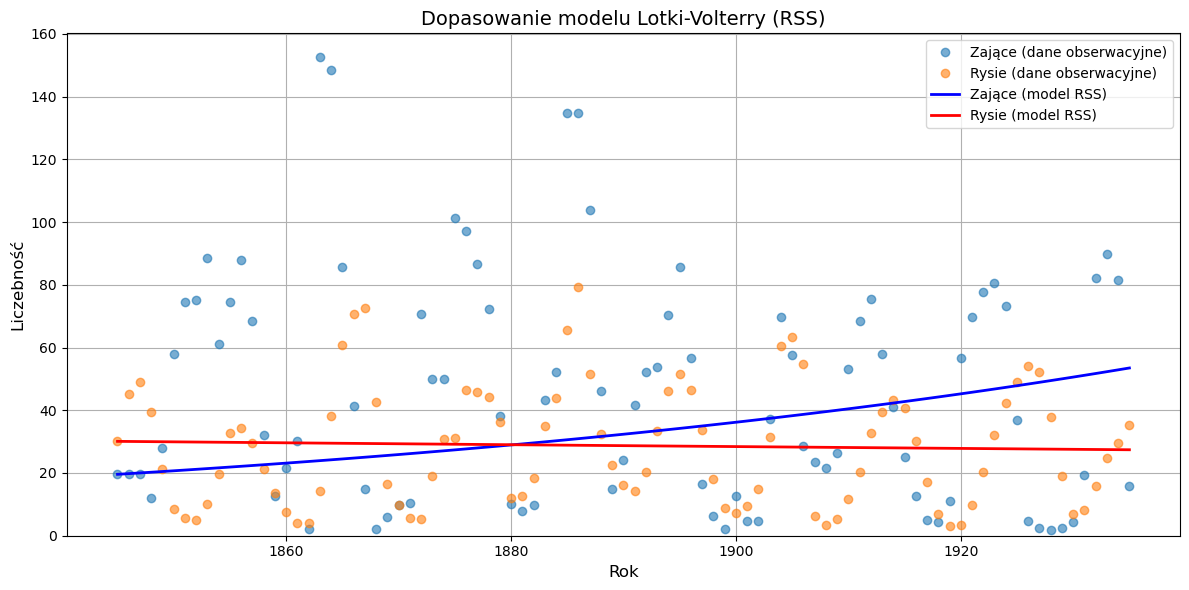

In [129]:
def cost_function_rss(theta, initial_cond, t_points, h_obs, l_obs):
    sim_h, sim_l = simulate_lotka_volterra(theta, initial_cond, t_points)

    # Upewnij się, że długości tablic są takie same, obetnij jeśli symulacja jest dłuższa
    min_len = min(len(sim_h), len(h_obs))

    rss = np.sum((h_obs[:min_len] - sim_h[:min_len]) ** 2) + np.sum(
        (l_obs[:min_len] - sim_l[:min_len]) ** 2
    )
    return rss


# Minimalizacja funkcji kosztu RSS
print("Minimalizacja funkcji kosztu: Suma Kwadratów Reszt (RSS)")
result_rss = minimize(
    cost_function_rss,
    initial_theta,
    args=(initial_conditions_obs, time_points, hare_obs, lynx_obs),
    method="Nelder-Mead",
    options={"disp": True, "maxiter": 5000},
)

estimated_theta_rss = result_rss.x
print(
    f"Oszacowane parametry (RSS): α1={estimated_theta_rss[0]:.4f}, α2={estimated_theta_rss[1]:.4f}, β1={estimated_theta_rss[2]:.4f}, β2={estimated_theta_rss[3]:.4f}"
)

# Wizualizacja dopasowania dla RSS
sim_hare_rss, sim_lynx_rss = simulate_lotka_volterra(
    estimated_theta_rss, initial_conditions_obs, time_points
)

plt.figure(figsize=(12, 6))
plt.plot(years, hare_obs, "o", label="Zające (dane obserwacyjne)", alpha=0.6)
plt.plot(years, lynx_obs, "o", label="Rysie (dane obserwacyjne)", alpha=0.6)
plt.plot(
    years, sim_hare_rss[: len(years)], "-", label="Zające (model RSS)", color="blue"
)
plt.plot(years, sim_lynx_rss[: len(years)], "-", label="Rysie (model RSS)", color="red")
plt.title("Dopasowanie modelu Lotki-Volterry (RSS)")
plt.xlabel("Rok")
plt.ylabel("Liczebność")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()

#### Funkcja kosztu oparta na funkcji wiarygodności (Poisson-like)


Minimalizacja funkcji kosztu: Oparta na funkcji wiarygodności (Poisson-like)
Optimization terminated successfully.
         Current function value: -17213.491496
         Iterations: 172
         Function evaluations: 298
Oszacowane parametry (Likelihood): α1=1.2317, α2=0.1048, β1=-0.0371, β2=-0.0004


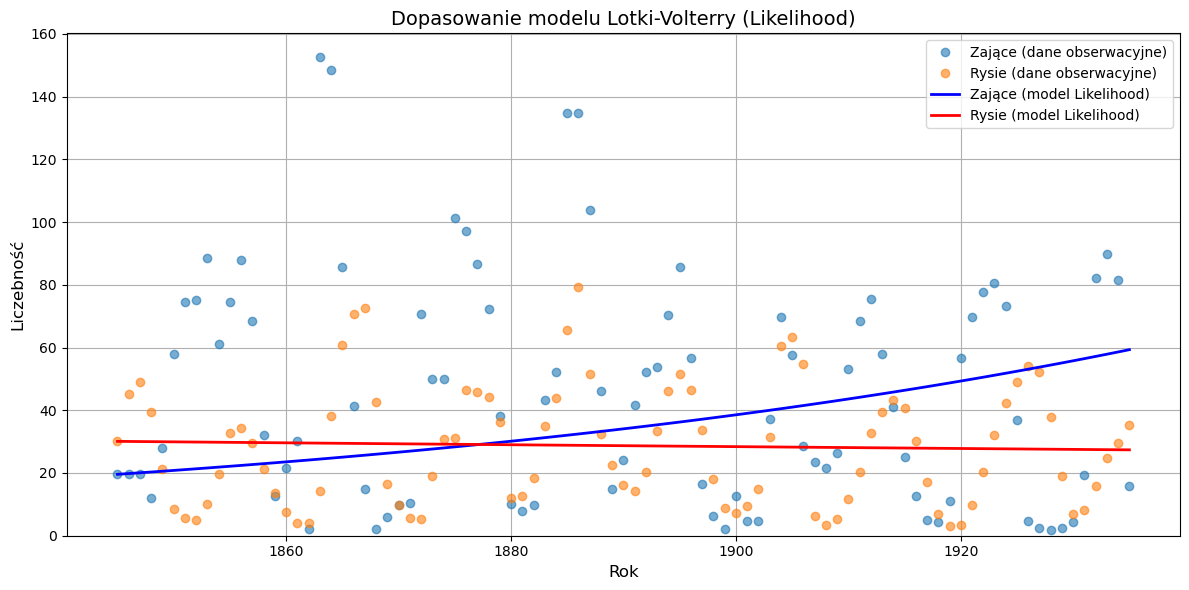

In [130]:
def cost_function_likelihood(theta, initial_cond, t_points, h_obs, l_obs):
    sim_h, sim_l = simulate_lotka_volterra(theta, initial_cond, t_points)

    # Upewnij się, że długości tablic są takie same, obetnij jeśli symulacja jest dłuższa
    min_len = min(len(sim_h), len(h_obs))

    # Zabezpieczenie przed logarytmem z zera lub wartości ujemnych
    sim_h_safe = np.maximum(sim_h[:min_len], 1e-9)
    sim_l_safe = np.maximum(sim_l[:min_len], 1e-9)

    # Należy pamiętać, że l_i i h_i są również liczbami, więc ich ln(0) może się pojawić,
    # jeśli dane zawierają zera. Zakładamy, że dane są > 0.

    cost = (
        -np.sum(l_obs[:min_len] * np.log(sim_l_safe))
        - np.sum(h_obs[:min_len] * np.log(sim_h_safe))
        + np.sum(sim_l_safe)
        + np.sum(sim_h_safe)
    )
    return cost


# Minimalizacja funkcji kosztu - Likelihood
print("\nMinimalizacja funkcji kosztu: Oparta na funkcji wiarygodności (Poisson-like)")
result_likelihood = minimize(
    cost_function_likelihood,
    initial_theta,
    args=(initial_conditions_obs, time_points, hare_obs, lynx_obs),
    method="Nelder-Mead",
    options={"disp": True, "maxiter": 5000},
)

estimated_theta_likelihood = result_likelihood.x
print(
    f"Oszacowane parametry (Likelihood): α1={estimated_theta_likelihood[0]:.4f}, α2={estimated_theta_likelihood[1]:.4f}, β1={estimated_theta_likelihood[2]:.4f}, β2={estimated_theta_likelihood[3]:.4f}"
)

# Wizualizacja dopasowania dla Likelihood
sim_hare_likelihood, sim_lynx_likelihood = simulate_lotka_volterra(
    estimated_theta_likelihood, initial_conditions_obs, time_points
)

plt.figure(figsize=(12, 6))
plt.plot(years, hare_obs, "o", label="Zające (dane obserwacyjne)", alpha=0.6)
plt.plot(years, lynx_obs, "o", label="Rysie (dane obserwacyjne)", alpha=0.6)
plt.plot(
    years,
    sim_hare_likelihood[: len(years)],
    "-",
    label="Zające (model Likelihood)",
    color="blue",
)
plt.plot(
    years,
    sim_lynx_likelihood[: len(years)],
    "-",
    label="Rysie (model Likelihood)",
    color="red",
)
plt.title("Dopasowanie modelu Lotki-Volterry (Likelihood)")
plt.xlabel("Rok")
plt.ylabel("Liczebność")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()

In [131]:
print("\n--- Podsumowanie Oszacowanych Parametrów ---")
print("Parametry początkowe (domyślne):")
print(f"  α1 = {alpha1:.4f}, α2 = {alpha2:.4f}, β1 = {beta1:.4f}, β2 = {beta2:.4f}")

print("\nOszacowane parametry (metoda RSS):")
print(
    f"  α1 = {estimated_theta_rss[0]:.4f}, α2 = {estimated_theta_rss[1]:.4f}, β1 = {estimated_theta_rss[2]:.4f}, β2 = {estimated_theta_rss[3]:.4f}"
)
print(f"  Wartość funkcji kosztu (RSS): {result_rss.fun:.4f}")

print("\nOszacowane parametry (metoda Likelihood):")
print(
    f"  α1 = {estimated_theta_likelihood[0]:.4f}, α2 = {estimated_theta_likelihood[1]:.4f}, β1 = {estimated_theta_likelihood[2]:.4f}, β2 = {estimated_theta_likelihood[3]:.4f}"
)
print(f"  Wartość funkcji kosztu (Likelihood): {result_likelihood.fun:.4f}")

print(
    "\nWizualizacje powyżej pokazują, jak dobrze modele dopasowały się do danych. Wartości parametrów mogą się różnić w zależności od wybranej funkcji kosztu oraz początkowego zgadnięcia."
)


--- Podsumowanie Oszacowanych Parametrów ---
Parametry początkowe (domyślne):
  α1 = 1.0000, α2 = 0.5000, β1 = 0.1000, β2 = 0.0200

Oszacowane parametry (metoda RSS):
  α1 = 1.1166, α2 = 0.1036, β1 = -0.0028, β2 = -0.0001
  Wartość funkcji kosztu (RSS): 181370.4038

Oszacowane parametry (metoda Likelihood):
  α1 = 1.2317, α2 = 0.1048, β1 = -0.0371, β2 = -0.0004
  Wartość funkcji kosztu (Likelihood): -17213.4915

Wizualizacje powyżej pokazują, jak dobrze modele dopasowały się do danych. Wartości parametrów mogą się różnić w zależności od wybranej funkcji kosztu oraz początkowego zgadnięcia.
